# A/B Testing Case Study — Experimental Validation & Decision-Making

You have been assigned an analytical task for an international e-commerce platform.  
Previous analysts launched an A/B test but did not complete the analysis, leaving behind only the technical specifications and raw experimental data.

The objective of this case study is **not only to compare results**, but to critically assess the **validity of the experiment itself**, identify data limitations, and determine whether the outcomes support **sound, unbiased business decisions**.

---

## Technical Description

**Test name:** `recommender_system_test`

**Groups:**  
- **A** — Control group  
- **B** — New checkout funnel with an improved recommendation system  

**Test timeline:**  
- **Launch date:** 2020-12-07  
- **End of user enrollment:** 2020-12-21  
- **Test end date:** 2021-01-01  

**Audience:**  
15% of newly registered users from the **EU region**

**Purpose of the test:**  
To evaluate whether an enhanced recommendation system improves user progression through the purchase funnel.

**Target funnel events:**  
- `product_page`  
- `product_cart`  
- `purchase`

**Expected outcome:**  
Within **14 days after registration**, users in the test group were expected to show:
- Higher conversion rates at each funnel stage  
- A **minimum uplift of 10% per step** in the funnel  
  (`product_page → product_cart → purchase`)

**Planned sample size:**  
6,000 participants

---

## Analytical Focus

Rather than forcing a positive conclusion, this analysis prioritizes:

- Funnel behavior and conversion dynamics  
- Experimental integrity and group consistency  
- Statistical validity and power  
- Identification of design flaws, data leakage, and bias risks  

The goal is to provide **data-driven recommendations**, including scenarios where **no action should be taken** to avoid misleading or costly business decisions.

## Data Description

The analysis is based on four datasets provided as part of the A/B testing experiment.

---

### Data Sources

**`ab_project_marketing_events_us.csv`**  
Marketing events calendar for 2020.

**`final_ab_new_users_upd_us.csv`**  
All users who registered on the platform between **December 7 and December 21, 2020**.

**`final_ab_events_upd_us.csv`**  
All events generated by new users between **December 7, 2020 and January 1, 2021**.

**`final_ab_participants_upd_us.csv`**  
Table containing A/B test participation data.

---

### Dataset Schemas

#### `ab_project_marketing_events_us.csv`

- **`name`** — Marketing campaign name  
- **`regions`** — Regions where the campaign was active  
- **`start_dt`** — Campaign start date  
- **`finish_dt`** — Campaign end date  

---

#### `final_ab_new_users_upd_us.csv`

- **`user_id`** — Unique user identifier  
- **`first_date`** — Registration date  
- **`region`** — User region  
- **`device`** — Device used during registration  

---

#### `final_ab_events_upd_us.csv`

- **`user_id`** — Unique user identifier  
- **`event_dt`** — Event timestamp  
- **`event_name`** — Event type  
- **`details`** — Additional event information  
  (e.g., total order value in USD for `purchase` events)

---

#### `final_ab_participants_upd_us.csv`

- **`user_id`** — Unique user identifier  
- **`ab_test`** — Name of the A/B test  
- **`group`** — Assigned experimental group (A or B)

In [3]:
# =========================
# Imports
# =========================

# Core data handling
import pandas as pd
import numpy as np

# Static visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import (
    proportions_ztest,
    confint_proportions_2indep
)

# Interactive visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =========================
# Display & plotting options
# =========================

# Show all DataFrame columns
pd.set_option('display.max_columns', None)

## 🎯 Analysis Objectives

The purpose of this analysis is to evaluate the impact of a new recommendation system on user behavior within an online application. The study relies on user cohorts and event-level data collected during a controlled A/B experiment.

The analysis is structured around the following objectives:

---

### 1. 📊 Establish baseline user behavior

Prior to evaluating the A/B experiment, an exploratory analysis is conducted to establish baseline behavioral patterns, including:

- Frequency and volume of key user events.
- User activity segmented by region and device.
- Temporal trends in new user registrations.

This step provides essential context and helps identify anomalies that could affect experimental interpretation.

---

### 2. 🧪 Evaluate the A/B experiment (`recommender_system_test`)

The primary objective is to determine whether the new recommendation system leads to measurable behavioral changes. The evaluation includes:

- Comparison of key funnel metrics between control (A) and treatment (B) groups.
- Analysis of conversion performance across funnel stages.
- Application of statistical hypothesis testing to assess the significance of observed differences.

---

### 3. 🧼 Account for external influences

During the experiment period, multiple marketing campaigns were active and may have influenced user behavior. To reduce potential confounding effects, the analysis:

- Identifies user exposure to concurrent marketing events.
- Evaluates their potential impact on observed outcomes.
- Explicitly considers external sources of bias when interpreting results.

---

### 4. 🧠 Provide data-driven recommendations

Based on the analytical results:

- A recommendation is formulated regarding the potential deployment of the new recommendation system.
- Key limitations related to data quality, experimental design, and statistical power are explicitly documented.
- Decision scenarios are evaluated, including cases where results support action, further experimentation, or maintaining the current system due to insufficient statistical evidence.

## 🧹 Data Cleaning and Validation

- **Data types:**  
  Verification and conversion of variables to their appropriate formats (dates, categorical fields, numerical values).

- **Missing values:**  
  Identification of missing data, assessment of their frequency, and evaluation of their potential impact on subsequent analyses.

- **Duplicates:**  
  Detection of duplicate records at both the user and event levels, along with validation of whether they represent data quality issues or legitimate repeated behavior.

This step ensures that all conclusions derived from the A/B experiment are based on reliable, well-structured data.

In [4]:
# Load data and create DataFrames
marketing_events = pd.read_csv('data/ab_project_marketing_events_us.csv')
new_users = pd.read_csv('data/final_ab_new_users_upd_us.csv')
events = pd.read_csv('data/final_ab_events_upd_us.csv')
participants = pd.read_csv('data/final_ab_participants_upd_us.csv')

# Helper function to inspect basic dataset structure
def inspect_dataset(name, df):
    print(f"{name.upper()}:\n")
    df.info()
    print()
    display(df.head())
    print("\n\n")

# Inspect datasets
inspect_dataset("Marketing Events", marketing_events)
inspect_dataset("New Users", new_users)
inspect_dataset("Events", events)
inspect_dataset("Participants", participants)

MARKETING EVENTS:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes



,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11





NEW USERS:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB



,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone





EVENTS:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB



,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99





PARTICIPANTS:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB



,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [5]:
# Convert date columns to datetime format
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

new_users['first_date'] = pd.to_datetime(new_users['first_date'])

events['event_dt'] = pd.to_datetime(events['event_dt'])

# Confirm date format changes
marketing_events.info(), new_users.info(), events.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total

In [6]:
def dataset_summary(name, df):
    print(f"\n📋 SUMMARY FOR: {name.upper()}")

    # Duplicate rows
    print(f"Duplicates: {df.duplicated().sum()}")

    # Missing values per column
    print("\nMissing values by column:")
    print(df.isna().sum())

    # Unique values per column
    print("\n🔍 Unique values by column:")
    for col in df.columns:
        unique_count = df[col].nunique()
        print(f"   - {col}: {unique_count:,}")

    print("-" * 50)

dataset_summary("marketing_events", marketing_events)
dataset_summary("new_users", new_users)
dataset_summary("events", events)
dataset_summary("participants", participants)


📋 SUMMARY FOR: MARKETING_EVENTS
Duplicates: 0

Missing values by column:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

🔍 Unique values by column:
   - name: 14
   - regions: 6
   - start_dt: 14
   - finish_dt: 14
--------------------------------------------------

📋 SUMMARY FOR: NEW_USERS
Duplicates: 0

Missing values by column:
user_id       0
first_date    0
region        0
device        0
dtype: int64

🔍 Unique values by column:
   - user_id: 58,703
   - first_date: 17
   - region: 4
   - device: 4
--------------------------------------------------

📋 SUMMARY FOR: EVENTS
Duplicates: 0

Missing values by column:
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

🔍 Unique values by column:
   - user_id: 58,703
   - event_dt: 257,138
   - event_name: 4
   - details: 4
--------------------------------------------------

📋 SUMMARY FOR: PARTICIPANTS
Duplicates: 0

Missing values by column:
user_id    0
group      

In [7]:
# Inspect unique values in the 'details' column
print(events['details'].value_counts())

# Validate that 'details' is only populated for 'purchase' events
print(
    f"\nNull values in 'details' for 'purchase' events: "
    f"{events.query('event_name == \"purchase\"')['details'].isnull().sum()}"
)

print(
    f"Non-null 'details' values for non-'purchase' events: "
    f"{events.query('event_name != \"purchase\"')['details'].notnull().sum()}"
)

details
4.99      44579
9.99       9158
99.99      5405
499.99     1172
Name: count, dtype: int64

Null values in 'details' for 'purchase' events: 0
Non-null 'details' values for non-'purchase' events: 0


In [8]:
# Inspect different values in the 'ab_test' column
print(
    participants.query('ab_test != "recommender_system_test"').head(),
    "\n"
)

# Count users per A/B test
print(participants['ab_test'].value_counts())

               user_id group            ab_test
3675  D4E530F6595A05A3     A  interface_eu_test
3676  6BCB0F33D3BAB8C2     A  interface_eu_test
3677  FB6F6BC119E1DBD5     B  interface_eu_test
3678  2D2E7AA539CF348F     B  interface_eu_test
3679  4BA448BCE1343C6F     A  interface_eu_test 

ab_test
interface_eu_test          10850
recommender_system_test     3675
Name: count, dtype: int64


In [9]:
# Check whether all experiment participants are present in the new_users dataset
participants_in_new_users = participants['user_id'].isin(new_users['user_id']).all()

if participants_in_new_users:
    print("✅ All experiment participants are registered in the new users dataset.")
else:
    missing_users = participants.loc[
        ~participants['user_id'].isin(new_users['user_id'])
    ]
    print("⚠️ Some participants are not present in the new users dataset.")
    print(f"Missing users: {len(missing_users)}")
    display(missing_users.head())

✅ All experiment participants are registered in the new users dataset.


In [10]:
# Check unique values in key categorical columns
print("Unique values in 'region':", new_users['region'].unique())
print("Unique values in 'device':", new_users['device'].unique())

print("Unique values in 'group':", participants['group'].unique())
print("Unique values in 'ab_test':", participants['ab_test'].unique())

Unique values in 'region': ['EU' 'N.America' 'APAC' 'CIS']
Unique values in 'device': ['PC' 'Android' 'iPhone' 'Mac']
Unique values in 'group': ['A' 'B']
Unique values in 'ab_test': ['recommender_system_test' 'interface_eu_test']


In [11]:
# Check date ranges for datetime columns
print("MARKETING_EVENTS:")
print("start_dt:", marketing_events['start_dt'].min(), "→", marketing_events['start_dt'].max())
print("finish_dt:", marketing_events['finish_dt'].min(), "→", marketing_events['finish_dt'].max())
print()

print("NEW_USERS:")
print("first_date:", new_users['first_date'].min(), "→", new_users['first_date'].max())
print()

print("EVENTS:")
print("event_dt:", events['event_dt'].min(), "→", events['event_dt'].max())

MARKETING_EVENTS:
start_dt: 2020-01-25 00:00:00 → 2020-12-30 00:00:00
finish_dt: 2020-02-07 00:00:00 → 2021-01-07 00:00:00

NEW_USERS:
first_date: 2020-12-07 00:00:00 → 2020-12-23 00:00:00

EVENTS:
event_dt: 2020-12-07 00:00:33 → 2020-12-30 23:36:33


## Conclusions: Data Cleaning and Validation

- No duplicate records were found across the four DataFrames (`marketing_events`, `new_users`, `events`, `participants`).
- The only column containing missing values is `details` in the `events` dataset, which is expected since this field is populated exclusively for `purchase` events.
- The `details` column contains only four unique values (`4.99`, `9.99`, `99.99`, `499.99`), indicating a limited and well-defined set of products or services.
- Key categorical columns such as `region`, `device`, `group`, and `ab_test` were reviewed and showed consistent, valid values.
- All `user_id` values present in the `events` dataset are also found in `new_users`, ensuring full traceability of user activity.
- All users listed in `participants` are included in `new_users`, confirming that all test participants are newly registered users.
- Date ranges across the main datasets were validated and showed no logical inconsistencies or problematic overlaps.
- Two distinct A/B tests were identified in the `ab_test` column; however, this analysis focuses exclusively on `recommender_system_test`, as it is the only experiment documented and supported by sufficient data.

> With the data validated and cleaned, the analysis can proceed to the exploratory review of overall user behavior prior to evaluating the A/B experiment.

# EDA — Exploratory Data Analysis

##### Study user conversion across the different stages of the funnel.

The exploratory analysis focuses on understanding baseline user behavior before evaluating the A/B test results. The following questions guide this phase:

- How does conversion evolve across the funnel stages?
- Is the number of events per user evenly distributed between the experimental groups?
- Are there users appearing in both samples?
- How is event activity distributed over time (by day)?
- Are there any data peculiarities or structural issues that should be considered before running the A/B test?

This step provides critical context to assess experimental validity and to identify potential biases or confounding factors that may affect the interpretation of the test results.

In [12]:
# Merge new_users with participants to obtain full participant information
ab_users = participants.merge(new_users, on='user_id', how='inner')

ab_users.info()
print()
display(ab_users.sample(5))

# Filter users belonging only to the 'recommender_system_test'
ab_recommender = ab_users[ab_users['ab_test'] == 'recommender_system_test']
print()
ab_recommender.info()
print()
display(ab_recommender.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     14525 non-null  object        
 1   group       14525 non-null  object        
 2   ab_test     14525 non-null  object        
 3   first_date  14525 non-null  datetime64[ns]
 4   region      14525 non-null  object        
 5   device      14525 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 681.0+ KB



,user_id,group,ab_test,first_date,region,device
1636,6F70F06DD209676B,A,recommender_system_test,2020-12-13,EU,PC
12297,9F15AB8A7F968248,A,interface_eu_test,2020-12-18,EU,PC
12825,9424487EC5359533,B,interface_eu_test,2020-12-15,EU,Android
1882,FFF28D02B1EACBE1,B,recommender_system_test,2020-12-16,EU,PC
7371,E208FA935547C2C5,B,interface_eu_test,2020-12-19,EU,Android



<class 'pandas.core.frame.DataFrame'>
Index: 3675 entries, 0 to 3674
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     3675 non-null   object        
 1   group       3675 non-null   object        
 2   ab_test     3675 non-null   object        
 3   first_date  3675 non-null   datetime64[ns]
 4   region      3675 non-null   object        
 5   device      3675 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 201.0+ KB



,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,4FF2998A348C484F,A,recommender_system_test,2020-12-20,EU,Mac


In [13]:
# Check whether the claim "15% of new users are from the EU" holds for the recommender A/B test
ab_slice = ab_recommender.query(
    'ab_test == "recommender_system_test" & region != "EU" & '
    'first_date >= "2020-12-07" & first_date <= "2020-12-30"'
)

# Distribution of regions for new users outside the EU
display(ab_slice.head())
print(ab_slice['region'].value_counts(), "\n")

# Distribution of non-EU users across A/B test groups
print(ab_slice['group'].value_counts())

,user_id,group,ab_test,first_date,region,device
3481,800AF45A68291849,A,recommender_system_test,2020-12-07,N.America,Android
3482,D2EE314AAEA02F72,A,recommender_system_test,2020-12-21,N.America,Android
3483,2A5675463AECCD76,A,recommender_system_test,2020-12-18,N.America,Android
3484,9D8E1DFF5B436455,A,recommender_system_test,2020-12-21,N.America,Android
3485,97845CC971F6A022,A,recommender_system_test,2020-12-18,N.America,PC


region
N.America    119
APAC          45
CIS           30
Name: count, dtype: int64 

group
A    143
B     51
Name: count, dtype: int64


In [14]:
# Ensure that user registration dates fall within the experiment timeframe
print("Date range for 'first_date' (new user registrations in the recommender A/B test):")
print(f" Minimum: {ab_recommender['first_date'].min()}")
print(f" Maximum: {ab_recommender['first_date'].max()}")

Date range for 'first_date' (new user registrations in the recommender A/B test):
 Minimum: 2020-12-07 00:00:00
 Maximum: 2020-12-21 00:00:00


In [15]:
# Check unique event types
print(events['event_name'].value_counts())

# Merge events with participants from the recommender_system_test
ab_events = events.merge(ab_recommender, on='user_id', how='inner')

print()
ab_events.info()
print()
display(ab_events.sample(5))

event_name
login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23909 entries, 0 to 23908
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     23909 non-null  object        
 1   event_dt    23909 non-null  datetime64[ns]
 2   event_name  23909 non-null  object        
 3   details     3210 non-null   float64       
 4   group       23909 non-null  object        
 5   ab_test     23909 non-null  object        
 6   first_date  23909 non-null  datetime64[ns]
 7   region      23909 non-null  object        
 8   device      23909 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.6+ MB



,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
19747,F0BFCAD95429C41D,2020-12-20 08:46:59,login,NaN,A,recommender_system_test,2020-12-20,EU,Android
12214,B043E52A918CDD6E,2020-12-24 06:18:26,product_page,NaN,A,recommender_system_test,2020-12-17,EU,PC
18947,B443345D2BB1A960,2020-12-19 05:21:50,login,NaN,A,recommender_system_test,2020-12-19,EU,Android
17709,51402781371A5122,2020-12-18 12:38:41,login,NaN,A,recommender_system_test,2020-12-14,EU,Android
13697,020A95B66F363AFB,2020-12-09 21:08:40,login,NaN,B,recommender_system_test,2020-12-07,EU,iPhone


In [16]:
# Create a user-level event matrix, keeping test group information
user_event_matrix = ab_events.pivot_table(
    index=['user_id', 'group'],
    columns='event_name',
    values='event_dt',
    aggfunc='count',
    fill_value=0
)

# Funnel Path 1: login → product_page → product_cart → purchase
user_event_matrix['path_1'] = (
    (user_event_matrix['login'] > 0) &
    (user_event_matrix['product_page'] > 0) &
    (user_event_matrix['product_cart'] > 0) &
    (user_event_matrix['purchase'] > 0)
)

# Funnel Path 2: login → product_page → purchase (no cart)
user_event_matrix['path_2'] = (
    (user_event_matrix['login'] > 0) &
    (user_event_matrix['product_page'] > 0) &
    (user_event_matrix['product_cart'] == 0) &
    (user_event_matrix['purchase'] > 0)
)

# Funnel Path 3: login → direct purchase (no product page, no cart)
user_event_matrix['path_3'] = (
    (user_event_matrix['login'] > 0) &
    (user_event_matrix['product_page'] == 0) &
    (user_event_matrix['product_cart'] == 0) &
    (user_event_matrix['purchase'] > 0)
)

# Display total user counts per path (regardless of group)
print("Users in Path 1:", user_event_matrix['path_1'].sum())
print("Users in Path 2:", user_event_matrix['path_2'].sum())
print("Users in Path 3:", user_event_matrix['path_3'].sum())

# Users with no purchase
no_purchase = user_event_matrix[user_event_matrix['purchase'] == 0].shape[0]
print("Users with no purchase:", no_purchase)

# Total users
print("Total users:", user_event_matrix.shape[0])

Users in Path 1: 225
Users in Path 2: 545
Users in Path 3: 237
Users with no purchase: 2547
Total users: 3675


In [17]:
# ---------- PATH 1 ----------
# Step 1: users who logged in
login_users = user_event_matrix[user_event_matrix['login'] > 0]
p1 = login_users.shape[0]

# Step 2: users who viewed a product page
p2 = login_users[login_users['product_page'] > 0].shape[0]

# Step 3: users who added a product to the cart
p3 = login_users[
    (login_users['product_page'] > 0) &
    (login_users['product_cart'] > 0)
].shape[0]

# Step 4: users who completed a purchase
p4 = login_users[
    (login_users['product_page'] > 0) &
    (login_users['product_cart'] > 0) &
    (login_users['purchase'] > 0)
].shape[0]

print("--- Path 1 ---")
print("Login:", p1)
print("Product Page:", p2)
print("Cart:", p3)
print("Purchase:", p4)

# ---------- PATH 2 ----------
# Step 1: login
r2_login = user_event_matrix[user_event_matrix['login'] > 0]

# Step 2: product page view
r2_step2 = r2_login[r2_login['product_page'] > 0]

# Step 3: purchase without going through cart
r2_final = r2_step2[
    (r2_step2['purchase'] > 0) & 
    (r2_step2['product_cart'] == 0)
]

print("\n--- Path 2 ---")
print("Login:", r2_login.shape[0])
print("Product Page:", r2_step2.shape[0])
print("Purchase (no product_cart):", r2_final.shape[0])

# ---------- PATH 3 ----------
# Users who purchased after login, without product_page or product_cart
r3_users = user_event_matrix[
    (user_event_matrix['purchase'] > 0) &
    (user_event_matrix['login'] > 0) &
    (user_event_matrix['product_page'] == 0) &
    (user_event_matrix['product_cart'] == 0)
]

print("\n--- Path 3 ---")
print("Login:", r2_login.shape[0])
print("Purchase (no product_page or product_cart):", r3_users.shape[0])

# Inspect users with purchase but no login (outside defined funnels)
print()
display(user_event_matrix[user_event_matrix['login'] == 0])

--- Path 1 ---
Login: 3674
Product Page: 2303
Cart: 685
Purchase: 225

--- Path 2 ---
Login: 3674
Product Page: 2303
Purchase (no product_cart): 545

--- Path 3 ---
Login: 3674
Purchase (no product_page or product_cart): 237



,event_name,login,product_cart,product_page,purchase,path_1,path_2,path_3
user_id,group,,,,,,,
5FF8B6AB257B404F,B,0,0,0,1,False,False,False


In [18]:
# Split by experiment group
grouped = user_event_matrix.reset_index().groupby('group')

# Container for funnel metrics
summary = []

for group_name, df in grouped:
    # ---------- PATH 1 ----------
    r1_login = df[df['login'] > 0]
    r1_p1 = r1_login.shape[0]
    r1_p2 = r1_login[r1_login['product_page'] > 0].shape[0]
    r1_p3 = r1_login[
        (r1_login['product_page'] > 0) &
        (r1_login['product_cart'] > 0)
    ].shape[0]
    r1_p4 = r1_login[
        (r1_login['product_page'] > 0) &
        (r1_login['product_cart'] > 0) &
        (r1_login['purchase'] > 0)
    ].shape[0]

    # ---------- PATH 2 ----------
    r2_login = df[df['login'] > 0]
    r2_p1 = r2_login.shape[0]
    r2_p2 = r2_login[r2_login['product_page'] > 0].shape[0]
    r2_p3 = r2_login[
        (r2_login['product_page'] > 0) &
        (r2_login['product_cart'] == 0) &
        (r2_login['purchase'] > 0)
    ].shape[0]

    # ---------- PATH 3 ----------
    r3_users = df[
        (df['login'] > 0) &
        (df['product_page'] == 0) &
        (df['product_cart'] == 0) &
        (df['purchase'] > 0)
    ].shape[0]

    summary.append({
        'Group': group_name,
        'Path 1 - Login': r1_p1,
        'Path 1 - Product Page': r1_p2,
        'Path 1 - Product Cart': r1_p3,
        'Path 1 - Purchase': r1_p4,
        'Path 2 - Login': r2_p1,
        'Path 2 - Product Page': r2_p2,
        'Path 2 - Direct Purchase': r2_p3,
        'Path 3 - Purchase without Page/Cart': r3_users
    })

# Build summary DataFrame
df_summary = pd.DataFrame(summary)
display(df_summary)

,Group,Path 1 - Login,Path 1 - Product Page,Path 1 - Product Cart,Path 1 - Purchase,Path 2 - Login,Path 2 - Product Page,Path 2 - Direct Purchase,Path 3 - Purchase without Page/Cart
0,A,2747,1780,540,176,2747,1780,434,171
1,B,927,523,145,49,927,523,111,66


In [19]:
# Build stage-to-stage conversion rates by group
stage_conversions = []

for _, row in df_summary.iterrows():
    group = row['Group']

    # -------- Path 1 --------
    r1_login = row['Path 1 - Login']
    r1_page = row['Path 1 - Product Page']
    r1_cart = row['Path 1 - Product Cart']
    r1_purchase = row['Path 1 - Purchase']

    if r1_login > 0:
        stage_conversions.append({
            'Group': group,
            'Path': 'Path 1',
            'Transition': 'Login → Product Page',
            'Users': r1_page,
            'Conversion rate': f"{r1_page / r1_login:.1%}"
        })

    if r1_page > 0:
        stage_conversions.append({
            'Group': group,
            'Path': 'Path 1',
            'Transition': 'Product Page → Product Cart',
            'Users': r1_cart,
            'Conversion rate': f"{r1_cart / r1_page:.1%}"
        })

    if r1_cart > 0:
        stage_conversions.append({
            'Group': group,
            'Path': 'Path 1',
            'Transition': 'Product Cart → Purchase',
            'Users': r1_purchase,
            'Conversion rate': f"{r1_purchase / r1_cart:.1%}"
        })

    # -------- Path 2 --------
    r2_login = row['Path 2 - Login']
    r2_page = row['Path 2 - Product Page']
    r2_purchase = row['Path 2 - Direct Purchase']

    if r2_login > 0:
        stage_conversions.append({
            'Group': group,
            'Path': 'Path 2',
            'Transition': 'Login → Product Page',
            'Users': r2_page,
            'Conversion rate': f"{r2_page / r2_login:.1%}"
        })

    if r2_page > 0:
        stage_conversions.append({
            'Group': group,
            'Path': 'Path 2',
            'Transition': 'Product Page → Purchase (no cart)',
            'Users': r2_purchase,
            'Conversion rate': f"{r2_purchase / r2_page:.1%}"
        })

    # -------- Path 3 --------
    # Note: Path 3 conversion is expressed relative to logins (same denominator as other paths)
    r3_login = row['Path 1 - Login']  # same login base
    r3_purchase = row['Path 3 - Purchase without Page/Cart']

    if r3_login > 0:
        stage_conversions.append({
            'Group': group,
            'Path': 'Path 3',
            'Transition': 'Login → Purchase (no product page / no cart)',
            'Users': r3_purchase,
            'Conversion rate': f"{r3_purchase / r3_login:.1%}"
        })

df_stage_conversions = pd.DataFrame(stage_conversions)
print("\nStage-to-stage conversion rates:")
display(df_stage_conversions)

# ---------------------------------------------------------------------------

# Build cumulative conversion rates by group and path
cumulative_conversions = []

for _, row in df_summary.iterrows():
    group = row['Group']

    # -------- Path 1 (cumulative from Login) --------
    if row['Path 1 - Login'] > 0:
        cumulative_conversions.append({
            'Group': group,
            'Path': 'Path 1',
            'Final stage': 'Product Page',
            'Users': row['Path 1 - Product Page'],
            'Cumulative rate': f"{row['Path 1 - Product Page'] / row['Path 1 - Login']:.1%}"
        })
        cumulative_conversions.append({
            'Group': group,
            'Path': 'Path 1',
            'Final stage': 'Product Cart',
            'Users': row['Path 1 - Product Cart'],
            'Cumulative rate': f"{row['Path 1 - Product Cart'] / row['Path 1 - Login']:.1%}"
        })
        cumulative_conversions.append({
            'Group': group,
            'Path': 'Path 1',
            'Final stage': 'Purchase (via Cart)',
            'Users': row['Path 1 - Purchase'],
            'Cumulative rate': f"{row['Path 1 - Purchase'] / row['Path 1 - Login']:.1%}"
        })

    # -------- Path 2 (cumulative from Login) --------
    if row['Path 2 - Login'] > 0:
        cumulative_conversions.append({
            'Group': group,
            'Path': 'Path 2',
            'Final stage': 'Direct Purchase (no cart)',
            'Users': row['Path 2 - Direct Purchase'],
            'Cumulative rate': f"{row['Path 2 - Direct Purchase'] / row['Path 2 - Login']:.1%}"
        })

    # -------- Path 3 (cumulative from Login) --------
    if row['Path 1 - Login'] > 0:
        cumulative_conversions.append({
            'Group': group,
            'Path': 'Path 3',
            'Final stage': 'Purchase (no Product Page/Cart)',
            'Users': row['Path 3 - Purchase without Page/Cart'],
            'Cumulative rate': f"{row['Path 3 - Purchase without Page/Cart'] / row['Path 1 - Login']:.1%}"
        })

df_cumulative_conversions = pd.DataFrame(cumulative_conversions)
print("\n\nCumulative conversion rates by path:")
display(df_cumulative_conversions)


Stage-to-stage conversion rates:


,Group,Path,Transition,Users,Conversion rate
0,A,Path 1,Login → Product Page,1780,64.8%
1,A,Path 1,Product Page → Product Cart,540,30.3%
2,A,Path 1,Product Cart → Purchase,176,32.6%
3,A,Path 2,Login → Product Page,1780,64.8%
4,A,Path 2,Product Page → Purchase (no cart),434,24.4%
5,A,Path 3,Login → Purchase (no product page / no cart),171,6.2%
6,B,Path 1,Login → Product Page,523,56.4%
7,B,Path 1,Product Page → Product Cart,145,27.7%
8,B,Path 1,Product Cart → Purchase,49,33.8%
9,B,Path 2,Login → Product Page,523,56.4%




Cumulative conversion rates by path:


,Group,Path,Final stage,Users,Cumulative rate
0,A,Path 1,Product Page,1780,64.8%
1,A,Path 1,Product Cart,540,19.7%
2,A,Path 1,Purchase (via Cart),176,6.4%
3,A,Path 2,Direct Purchase (no cart),434,15.8%
4,A,Path 3,Purchase (no Product Page/Cart),171,6.2%
5,B,Path 1,Product Page,523,56.4%
6,B,Path 1,Product Cart,145,15.6%
7,B,Path 1,Purchase (via Cart),49,5.3%
8,B,Path 2,Direct Purchase (no cart),111,12.0%
9,B,Path 3,Purchase (no Product Page/Cart),66,7.1%


### 🔎 Conversion journeys overview

User behavior was decomposed into **three distinct conversion journeys** to avoid masking structurally different purchase patterns:

- **Journey 1 — Full funnel**  
  `Login → Product Page → Product Cart → Purchase`  
  Represents the standard, fully tracked purchase flow.

- **Journey 2 — Direct purchase after product view**  
  `Login → Product Page → Purchase`  
  Captures users who complete a purchase without adding items to the cart.

- **Journey 3 — Immediate purchase**  
  `Login → Purchase`  
  Includes users who convert without visiting a product page or cart, potentially reflecting shortcut flows, returning intent, or tracking limitations.

Separating these journeys allows clearer interpretation of conversion behavior and prevents misleading conclusions that could arise from aggregating heterogeneous user paths.

In [20]:
# ------------------------------------------------------------
# Funnel charts (A vs B) by path, using user_event_matrix (no hardcode)
# ------------------------------------------------------------

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Stages (keep 5 rows to show "Direct Purchase" separately)
stages = ["Login", "Product Page", "Product Cart", "Purchase (via Cart)", "Direct Purchase"]

colors = {
    "Path 1": "rgba(90, 120, 255, 0.8)",
    "Path 2": "rgba(0, 200, 150, 0.8)",
    "Path 3": "rgba(255, 150, 80, 0.8)",
}

def build_path_counts(df_group):
    login_mask = df_group["login"] > 0
    n_login = login_mask.sum()

    # Path 1: login -> product_page -> product_cart -> purchase
    n_page = (login_mask & (df_group["product_page"] > 0)).sum()
    n_cart = (login_mask & (df_group["product_page"] > 0) & (df_group["product_cart"] > 0)).sum()
    n_purchase_cart = (
        login_mask &
        (df_group["product_page"] > 0) &
        (df_group["product_cart"] > 0) &
        (df_group["purchase"] > 0)
    ).sum()

    # Path 2: login -> product_page -> purchase WITHOUT cart
    n_purchase_direct = (
        login_mask &
        (df_group["product_page"] > 0) &
        (df_group["product_cart"] == 0) &
        (df_group["purchase"] > 0)
    ).sum()

    # Path 3: login -> purchase WITHOUT product_page and WITHOUT cart
    n_purchase_no_page_no_cart = (
        login_mask &
        (df_group["product_page"] == 0) &
        (df_group["product_cart"] == 0) &
        (df_group["purchase"] > 0)
    ).sum()

    return {
        "Path 1": [n_login, n_page, n_cart, n_purchase_cart, 0],
        "Path 2": [n_login, n_page, 0, 0, n_purchase_direct],
        "Path 3": [n_login, 0, 0, 0, n_purchase_no_page_no_cart],
    }

def add_funnels(fig, counts_dict, col, showlegend):
    for path, vals in counts_dict.items():
        base = vals[0] if vals[0] else 1
        labels = [f"{v} ({v/base*100:.1f}%)" if v > 0 else "" for v in vals]

        fig.add_trace(
            go.Funnel(
                y=stages,
                x=vals,
                text=labels,
                textposition="inside",
                marker_color=colors[path],
                name=path,
                opacity=0.85,
                hoverinfo="name+x+text",
                showlegend=showlegend,
            ),
            row=1,
            col=col,
        )

def purchase_rates(counts_dict):
    base = counts_dict["Path 1"][0] if counts_dict["Path 1"][0] else 1
    r1 = counts_dict["Path 1"][3] / base  # purchase via cart
    r2 = counts_dict["Path 2"][4] / base  # direct purchase after page
    r3 = counts_dict["Path 3"][4] / base  # direct purchase without page/cart
    return r1, r2, r3

# ---- Prepare data ----
uem = user_event_matrix.reset_index().copy()

counts_A = build_path_counts(uem[uem["group"] == "A"])
counts_B = build_path_counts(uem[uem["group"] == "B"])

r1A, r2A, r3A = purchase_rates(counts_A)
r1B, r2B, r3B = purchase_rates(counts_B)

# ---- Plot ----
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{"type": "funnel"}, {"type": "funnel"}]],
    subplot_titles=("Group A", "Group B"),
)

add_funnels(fig, counts_A, col=1, showlegend=True)
add_funnels(fig, counts_B, col=2, showlegend=False)  # single legend

fig.update_layout(
    title="Conversion Funnels by Group and Path",
    height=620,
    width=1150, 
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.22,
        xanchor="center",
        x=0.5,
        title="Paths",
    ),
    paper_bgcolor="white",
)

fig.add_annotation(
    text=(f"Group A:<br>"
          f"Path 1: {r1A*100:.1f}%<br>"
          f"Path 2: {r2A*100:.1f}%<br>"
          f"Path 3: {r3A*100:.1f}%"),
    x=0.23, y=-0.25, showarrow=False, xref="paper", yref="paper", align="left"
)

fig.add_annotation(
    text=(f"Group B:<br>"
          f"Path 1: {r1B*100:.1f}%<br>"
          f"Path 2: {r2B*100:.1f}%<br>"
          f"Path 3: {r3B*100:.1f}%"),
    x=0.77, y=-0.25, showarrow=False, xref="paper", yref="paper", align="left"
)

show_plotly(fig)

In [21]:
# ------------------------------------------------------------
# Event count per user
# Assess activity distribution across experimental groups
# ------------------------------------------------------------

# Count total events generated by each user
user_events = (
    ab_events
    .groupby('user_id')
    .agg(
        event_count=('event_name', 'count'),
        group=('group', 'first')
    )
)

# Descriptive statistics of event counts by group
event_dist = user_events.groupby('group')['event_count'].describe()

# Inspect results
display(user_events.head(3))
display(event_dist)

,event_count,group
user_id,,
001064FEAAB631A1,6,B
0010A1C096941592,12,A
00341D8401F0F665,2,A


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,2747.0,6.780852,3.729768,1.0,4.0,6.0,9.0,24.0
B,928.0,5.691810,3.450350,1.0,3.0,5.0,8.0,28.0


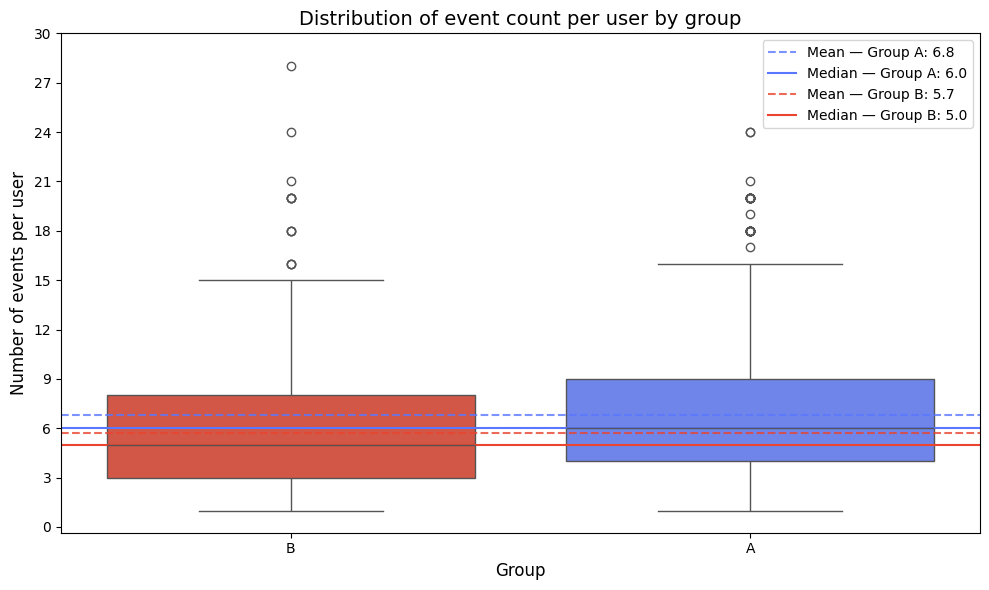

In [22]:
# ------------------------------------------------------------
# Boxplot: event count per user by experimental group
# Visual check for activity imbalance and outliers
# ------------------------------------------------------------

# Custom color palette
colors = {'A': '#5A78FF', 'B': '#E9452F'}

plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=user_events,
    x='group',
    y='event_count',
    hue='group',
    palette=colors,
    dodge=False,
    legend=False
)

# White background for consistency
ax.set_facecolor('white')

# Titles and labels
plt.title('Distribution of event count per user by group', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Number of events per user', fontsize=12)
plt.yticks(range(0, 31, 3))

# Compute mean and median per group
means = user_events.groupby('group')['event_count'].mean()
medians = user_events.groupby('group')['event_count'].median()

# Add horizontal lines for mean and median
for group in ['A', 'B']:
    mean_val = means[group]
    median_val = medians[group]

    ax.axhline(
        y=mean_val,
        color=colors[group],
        linestyle='--',
        linewidth=1.5,
        alpha=0.8,
        label=f'Mean — Group {group}: {mean_val:.1f}'
    )

    ax.axhline(
        y=median_val,
        color=colors[group],
        linestyle='-',
        linewidth=1.5,
        alpha=1,
        label=f'Median — Group {group}: {median_val:.1f}'
    )

# Deduplicate legend entries
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), loc='upper right')

plt.tight_layout()
plt.show()

Number of users assigned to both groups: 0



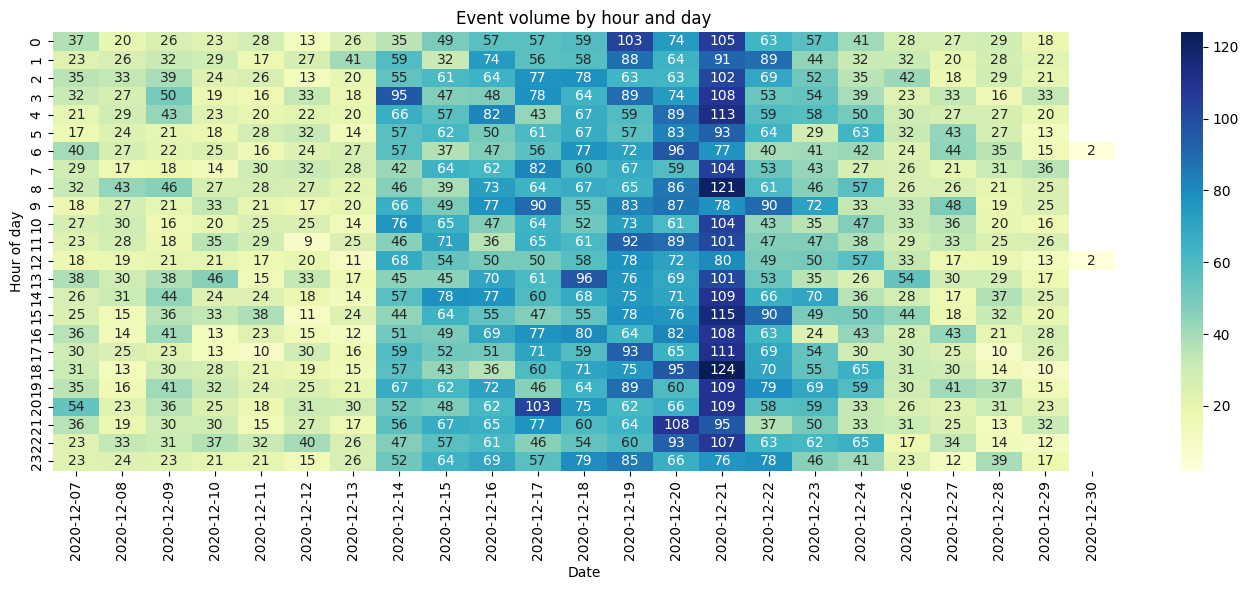

In [23]:
# ------------------------------------------------------------
# Validation checks:
# 1) Ensure no users appear in both A and B groups
# 2) Inspect temporal distribution of events (day × hour)
# ------------------------------------------------------------

# Check whether any user appears in both experimental groups
users_cross = ab_events.groupby('user_id')['group'].nunique()
users_cross = users_cross[users_cross > 1]

print(f"Number of users assigned to both groups: {len(users_cross)}\n")

# Create date and hour features
ab_events['event_date'] = ab_events['event_dt'].dt.date
ab_events['event_hour'] = ab_events['event_dt'].dt.hour

# Aggregate event counts by day and hour
events_day_time = (
    ab_events
    .groupby(['event_date', 'event_hour'])['event_name']
    .count()
    .reset_index()
    .rename(columns={'event_name': 'event_count'})
)

# Pivot for heatmap visualization
events_pivot = events_day_time.pivot(
    index='event_hour',
    columns='event_date',
    values='event_count'
)

# Heatmap: events by hour and day
plt.figure(figsize=(14, 6))
sns.heatmap(events_pivot, cmap='YlGnBu', annot=True, fmt='g')
plt.title('Event volume by hour and day')
plt.xlabel('Date')
plt.ylabel('Hour of day')
plt.tight_layout()
plt.show()

In [24]:
# ------------------------------------------------------------
# Check for overlapping marketing campaigns during the A/B test
# ------------------------------------------------------------

# Identify marketing campaigns that started during the A/B test period
display(
    marketing_events.query('start_dt >= "2020-12-07"')
)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


## Conclusions: Exploratory Data Analysis (EDA)

Ideally, an A/A test would have been conducted to verify that users were randomly and homogeneously assigned to the experimental groups prior to the start of the experiment. However, this validation step was not feasible given the available data.

The dataset only contains user events starting from December 7, 2020, which corresponds exactly to the launch date of the A/B test. As a result, no pre-experiment behavioral data is available to assess baseline equivalence between groups A and B.

This limitation prevents direct validation of random assignment and must be taken into account when interpreting subsequent differences observed between the experimental groups.

During the exploratory phase, data related to the `recommender_system_test` experiment was analyzed and prepared in order to evaluate whether a new recommendation system improves conversion among newly registered users across the purchase funnel.

Data cleaning and validation confirmed that all timestamps fall within the valid experimental window (December 7, 2020 to December 30, 2020), and that each user belongs to a single experimental group. The merge between users, test participants, and event-level data was successful, ensuring full traceability from user registration through behavioral events.

Although the experiment was originally specified as targeting only users from the EU region, 194 participants were identified from other regions (North America, APAC, and CIS). These users were deliberately retained in the analysis for the following reasons:

- They are valid participants explicitly included in the experiment.
- No evidence suggests that regional differences systematically bias the observed behavioral metrics.
- The total sample size is already below the planned 6,000 users, and excluding these observations would further reduce statistical power without a strong technical justification.

### Conversion Funnel Structure

Analysis of user behavior revealed **three distinct conversion paths** from login to purchase:

1. **Full funnel path**  
   `Login → Product Page → Product Cart → Purchase`  
   This represents the standard and most detailed navigation flow.

2. **Direct purchase from product page**  
   `Login → Product Page → Purchase (without product cart)`  
   A shortened path that bypasses the shopping cart step.

3. **Direct purchase without product page or cart**  
   `Login → Purchase`  
   A highly streamlined path potentially driven by external links, direct checkout access, or promotional campaigns.

In several cases, the **same user appears in more than one path**, reflecting multiple interactions over time. Since the objective is to evaluate **the effectiveness of each conversion route**, rather than to segment mutually exclusive users, these observations were intentionally preserved.

- Each event is valid and unique within its respective path.
- No duplication occurs from a funnel analysis perspective.
- This approach more accurately reflects real-world user behavior.

During data validation, at least one atypical case was identified where a purchase occurred without recorded `login`, `product_page`, or `product_cart` events. Possible explanations include:

- Event tracking inconsistencies.
- Guest checkout behavior.
- Direct access to checkout via external links (email, shared links, promotions).

The existence of the third path (`Login → Purchase`) should not automatically be treated as an anomaly. Instead, it likely represents **fast-conversion strategies**, commonly observed in remarketing or optimized checkout flows. Consequently, this path was retained as a meaningful component of the analysis.

### Event Distribution and User Activity

Despite the unequal group sizes (Group A ≈ 3,300 users vs. Group B ≈ 1,200 users), the distribution of events per user exhibits broadly similar statistical properties:

- Comparable means and standard deviations.
- Similar interquartile ranges.
- Boxplot analysis shows subtle differences: Group A displays a slightly higher median and more concentrated central distribution, while Group B exhibits a greater number of high-activity outliers, with some users generating more than 30 events.

No additional transformations or outlier exclusions were applied, as:

- Distributions are consistent with relative group sizes.
- No extreme distortions are observed.
- The variability aligns with expected behavior in digital commerce platforms.

### Temporal Patterns and Seasonality

The heatmap of events by day and hour shows sustained activity throughout the experiment, with a noticeable concentration between December 14 and December 24. While no marketing campaigns were officially active during the experimental window, the `marketing_events` dataset indicates that the “Christmas & New Year Promo” campaign began on December 25.

Although this campaign does not directly overlap with the experiment, the observed increase in activity during the days leading up to Christmas suggests **seasonal effects**, likely driven by last-minute holiday shopping behavior. This introduces a potential external influence on user behavior that is unrelated to the recommendation system itself.

#### Temporal Considerations

Hourly activity patterns show peak engagement between December 18 and December 22, aligning with typical pre-holiday purchasing behavior. Such seasonality may bias experimental results, as user decisions during this period can be influenced by urgency, holiday-driven demand, or broader consumption habits rather than by the tested intervention.

As a general best practice, A/B tests should avoid major holidays or special calendar periods, as these can obscure or distort the true effect of experimental changes. In this case, proximity to the December holiday season represents an important external factor that must be considered when interpreting downstream statistical results.

<i>With these considerations in mind, the dataset is deemed sufficiently prepared to proceed with statistical validation of the experiment.</i>

# A/B Test — Evaluation of the `recommender_system_test`

### Objectives of the A/B test analysis

The purpose of this section is to evaluate whether the introduction of the new recommendation system led to a statistically significant improvement in user conversion across key stages of the purchase funnel.

Specifically, the analysis aims to answer the following questions:

- Are there statistically significant differences in conversion rates between Group A (control) and Group B (treatment)?
- Do observed differences support the expected minimum uplift of **+10%** at each funnel stage (`product_page → product_cart → purchase`)?
- Are the results robust enough to justify a product decision, given the data limitations identified during the exploratory analysis?

To address these questions, **two-proportion z-tests** are applied to compare conversion rates between groups for each relevant funnel transition. Statistical significance is evaluated at a standard confidence level, with careful interpretation to avoid overestimating effects in the presence of external biases or limited statistical power.

In [25]:
# Inspect merged A/B events dataset
ab_events.info()
print()

# Count unique users who completed a purchase, by experimental group
unique_purchase = (
    ab_events[ab_events['event_name'] == "purchase"]
    .groupby('group')['user_id']
    .nunique()
)

display(unique_purchase)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23909 entries, 0 to 23908
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     23909 non-null  object        
 1   event_dt    23909 non-null  datetime64[ns]
 2   event_name  23909 non-null  object        
 3   details     3210 non-null   float64       
 4   group       23909 non-null  object        
 5   ab_test     23909 non-null  object        
 6   first_date  23909 non-null  datetime64[ns]
 7   region      23909 non-null  object        
 8   device      23909 non-null  object        
 9   event_date  23909 non-null  object        
 10  event_hour  23909 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), object(7)
memory usage: 1.9+ MB



group
A    872
B    256
Name: user_id, dtype: int64

In [26]:
# Inspect A/B test participants dataset
ab_recommender.info()

# Total number of unique users in the A/B test
print(f"\nTotal unique users in the test: {ab_recommender['user_id'].nunique()}\n")

# User count per experimental group
print(ab_recommender.groupby('group')['user_id'].count())

<class 'pandas.core.frame.DataFrame'>
Index: 3675 entries, 0 to 3674
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     3675 non-null   object        
 1   group       3675 non-null   object        
 2   ab_test     3675 non-null   object        
 3   first_date  3675 non-null   datetime64[ns]
 4   region      3675 non-null   object        
 5   device      3675 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 201.0+ KB

Total unique users in the test: 3675

group
A    2747
B     928
Name: user_id, dtype: int64


In [27]:
# Conversion data by group
success_a = 872
size_a = 2747

success_b = 256
size_b = 928

# Conversion rates
conv_a = success_a / size_a
conv_b = success_b / size_b

# Hypotheses
# H0: Conversion rate in group B ≤ group A (no improvement or worse)
# H1: Conversion rate in group B > group A (improvement in group B)

# Z-test for proportions (one-sided)
z_stat, p_val = proportions_ztest(
    [success_b, success_a],
    [size_b, size_a],
    alternative='larger'  # one-sided test: B > A
)

# Observed lift (%)
lift = (conv_b - conv_a) / conv_a * 100

# Results
print(f"Conversion rate A: {conv_a:.4f} ({conv_a*100:.1f}%)")
print(f"Conversion rate B: {conv_b:.4f} ({conv_b*100:.1f}%)\n")

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value (one-sided, B > A): {p_val:.4f}\n")

alpha = 0.05
if p_val < alpha:
    print("Reject H₀: Group B shows a statistically significant improvement.")
else:
    print("Fail to reject H₀: No sufficient evidence that group B converts better than group A.")

print(f"Observed lift: {lift:.2f}%")

Conversion rate A: 0.3174 (31.7%)
Conversion rate B: 0.2759 (27.6%)

Z-statistic: -2.3741
P-value (one-sided, B > A): 0.9912

Fail to reject H₀: No sufficient evidence that group B converts better than group A.
Observed lift: -13.10%


In [28]:
# Additional tests to formalize A > B (aligned with the observed negative effect for B)

# Two-sided test (A ≠ B)
z_two, p_two = proportions_ztest(
    [success_b, success_a],
    [size_b, size_a],
    alternative="two-sided"
)

# One-sided reverse test (B < A)
z_smaller, p_smaller = proportions_ztest(
    [success_b, success_a],
    [size_b, size_a],
    alternative="smaller"
)

# 95% confidence interval for difference in proportions (B − A), score method
ci_low, ci_high = confint_proportions_2indep(
    count1=success_b, nobs1=size_b,   # group B
    count2=success_a, nobs2=size_a,   # group A
    method="score"
)

print("Two-sided z-test (A ≠ B)")
print(f"Z-statistic: {z_two:.4f}")
print(f"P-value:     {p_two:.4f}\n")

print("One-sided z-test (B < A)")
print(f"Z-statistic: {z_smaller:.4f}")
print(f"P-value:     {p_smaller:.4f}\n")

print("95% CI for difference in proportions (B − A), score method")
print(f"({ci_low:.4f}, {ci_high:.4f})")

alpha = 0.05
if p_smaller < alpha:
    print("\n✅ Reject H₀: Group A converts significantly better than group B.")
else:
    print("\n❌ Fail to reject H₀: Not enough evidence to claim A converts better than B.")

Two-sided z-test (A ≠ B)
Z-statistic: -2.3741
P-value:     0.0176

One-sided z-test (B < A)
Z-statistic: -2.3741
P-value:     0.0088

95% CI for difference in proportions (B − A), score method
(-0.0744, -0.0074)

✅ Reject H₀: Group A converts significantly better than group B.


## Conclusions — A/B Test Results

A one-sided Z-test was first applied to evaluate whether **Group B outperformed Group A** in terms of conversion rate (`alternative='larger'`).  
The result showed **no statistical evidence to reject the null hypothesis**, with a p-value of **0.9912**, indicating that **Group B cannot be considered superior to Group A**.

Given that **Group B exhibited a lower observed conversion rate**, additional tests were conducted to formally assess this difference:

- A **one-sided Z-test** testing whether **Group B converts less than Group A** (`alternative='smaller'`) produced a p-value of **0.0088**, allowing rejection of the null hypothesis and indicating that **Group B converts significantly worse than Group A**.
- A **two-sided Z-test** (`alternative='two-sided'`) also confirmed a **statistically significant difference** between the groups, with a p-value of **0.0175**.

The observed **lift for Group B is −13.10% relative to Group A**, indicating a substantial decrease rather than the expected improvement.  
This result is further supported by the **95% confidence interval for the difference in proportions (B − A)**, computed using the **score method**: **(−0.0744, −0.0074)**.  
Since this interval **does not include zero**, it reinforces the statistical significance of the finding and confirms that **Group A consistently outperforms Group B**.

Additionally, **Group A shows a higher number of events per user**, suggesting stronger engagement and interaction levels. This behavioral pattern aligns with the higher conversion rate observed for Group A.

Overall, instead of achieving the expected **10% uplift in conversion**, **Group B underperforms**, with a conversion rate approximately **13% lower** than Group A.  
These results indicate that the new recommendation system **does not improve conversion performance** and may be **negatively affecting user behavior under the observed conditions**.